# Kernel Density Estimation

La estimacion de la densidas esta estrechamente relacionado con el aprendizaje no supervisado y la visualizacion de datos, asi como la deteccion de anomalias en los datos.

La tecnica de KDE nos ayudara a resolver estos problemas y otros muchos que nos encontremos de vez en cuando.

## El problema de los histogramas.

Un histograma es una tipo de visualizacion de datos unidimesionales, donde se definen unos rangos o "bins" de manera previa y se cuentan el numero de datos que cae en estos rangos para hacerse una idea de como se ven los datos en ese rango.

Esta es una de las maneras mas comunes de representar una unica variable e intentar aproximarnos a la visualizacion de la distribucion continua de densidad.

Nota: Para todos los ejemplos que vamos a representar vamos a utilizar una distribucion multimodal tal que:

$$z \sim Multinomial(\pi)$$

con $\pi$ como vector de probabilidades: $\pi_1 = 0.3$ y $\pi_2 =0.7$ 

donde:
$$x|z=1 \sim \mathcal{N}(0,1)$$
$$x|z=2 \sim \mathcal{N}(5,1)$$


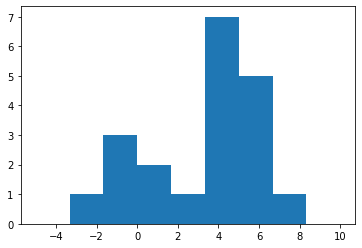

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(1)

N = 20

#Creamos un 
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)


plt.hist(X[:, 0], bins=bins);


El problema viene cuando elegimos los rangos de los posibles valores del historgrama, el el ejemplo siguiente podemos ver que si aumentamos el inicio del rango la distribucion obtenida es completamente diferente a la anterior lo que nos da algunas pistas de por donde van los tiros.

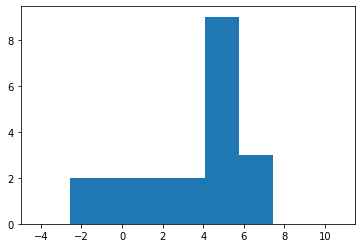

In [2]:
# histogram 2 +0.75 al inicio del rango
plt.hist(X[:, 0], bins=bins + 0.75);

Lo que pretendemos arreglar con KDE es la visualizacion de dicho histograma, la premisa es a priori sencilla pero, como podriamos lograr dicha mejora?.

Simple, suavizando la distribucion de puntos mediante funciones de suavizado o "kernel smoother[1]", un kernel no es mas que una funcion que tiene como input un vector en un espacio especifico y lo transforma en otro espacio n-dimensional; La finalidad de dicha transformacion es la de transformar un dato "raw" en un "feature vector" es decir una representacion que haga el usuario de los datos, por ejemplo la combinacion de variables o la transformacion de variables cualitativas a cuantitativas, este proceso puede realizarse con los kernel methods, donde el usuario proporciona una funcion de kernel espeicifico que ayuda a algunos algoritmos a realizar la separacion necesaria sobre los datos para aprenderlos.

En el caso que nos trae, tenemos un kernel smoother, la finalidad de este tipo de kernels es diferente a lo anteriormente explicado, queremos representar una funcion de valor real a partir de una media de los puntos observados en un determinado rango, en el caso de KDE lo que queremos representar es la funcion de densidad de la variable en cuestion.

Existen muchos tipos de kernels pero para ilustrar el ejemplo pondremos los mas significativos para aclarar ideas.

### Definicion formal de un kernel y uso como regresor no parametrico

La media que hemos ilustrado anteriormente es una "weigthed average" es decir una media con pesos, en la que esos "pesos" o coeficientes tienen un valor mas alto, para puntos cercanos al estimando, la funcion a estimar es una version suavizada de la funcion real que describe la forma de los datos y se controla mediante un parametro de suavizado $h$.

La forma general es la siguiente para calcular los pesos:

$$ K(x_0, x; h) = D(\frac{||x-x_0||}{h(x_0)})$$

La estimacion de la funcion o $\hat{f}(x_0)$ la siguiente:

$$\hat{f}(x_0) = \frac{\sum_{i=1}^{N}K_h(x_0, x_i)f(x_i)}{\sum_{i=1}^{N}K_h(x_0, x_i)}$$

donde $N$ es el numero de puntos observados e $f(x_i)$ es la funcion en dicho punto $x_i$, a esta media normalizada se la conoce como Nadaraya-Watson kernel-weighted average y ahora veremos los casos particulares de esta formulacion general.

### Neirest Neighbor smoother

Este es el tipo de kernel mas sencillo que podemos plantear y su razonamiento es tambien muy logico.

La idea es que para cada punto $x_0$ estimamos el valor de la funcion que queremos representar: $\hat{f}(x_0)$ como la media de los valores vecinos, usualmente se representa el numero de vecinos como K, formalmente: $$\hat{f}(x_0) = \frac{1}{K} \sum_{x_i\in N_k(x_0)} {y_i} $$
Donde $N_K$ es una funcion que llamamos de "neighborhood" para saber los $K$ vecinos, pero, como conseguimos dichos vecinos o con que criterio?, sencillo, los vecinos son los puntos mas cercanos al punto en cuestion $x_0$.

En este caso la distancia con la que comparamos los vecinos es la euclidiana.
$$d(x, y) = \sqrt{\sum_{i=0}^{N}(x_i-y_i)^2}$$
donde $x$ e $y$ son dos puntos con los que queremos comparar la distancia y $N$ es la dimension del espacio es decir el numero de "variables" de las que esta compuesta nuestro punto.

Un ejemplo unidimensional de lo mencionado anteriormente es:

![kernel]({static}/images/smoother.png)

Donde podemos ver la ventana de vecinos en amarillo, la cual forma un cuadrado debido a la distancia utilizada.


Si nos damos cuenta el resultado de la funcion a predecir sufre unos cortes, no es una funcion suave, esto se debe principalmente a que en cada puto $x_i$ estamos calculando los $K$ vecinos, esto nos da una prediccion pero para el punto siguiente tenemos un salto ya que estamos calculando posibles vecinos que no se encuentran en el anterior punto, provocando saltos y predicciones no suavizadas.

### Gaussian kernel smoother

El kernel gaussiano es otro de los mas utilizados y se forma de la siguiente manera:

$$
K(x^*, x_i; h) = \exp(-\frac{(x^*-x_i)^2}{2h^2})
$$

Este kernel hace referencia a la funcion gaussiana o de distribucion normal, podemos identificar varios terminos en este kernel, $x_i$ hace referencia a la media de los valores y $h$ que es un parametro de entrada proporcionado por el usuario llamado "bandwith" y que representa la desviacion estandar de la normal, de esta manera si aumentamos el "bandwith" aplanamos la curva en dicho punto.

La funcion resultante:


![gaussian]({static}/images/gaussian.png)

Como podemos ver, la ventana de pesos hace que se de mas importancia a los puntos mas cercanos a $x_0$ que a los mas alejados suavizando la curva y provocando que para otro punto $x_0$ la funcion no tenga dichos saltos como con neirest neighbor. 

El uso que le hemos dado en el caso anterior es como regresor es decir, queremos aproximar una funcion $Y$ a partir de unos datos $X$, la regresion que se aplica en este caso se dice que es un modelo no parametrico que implica que la complejidad del modelo crece con el numero de datos, esto no implica que estos modelos no tengan parametros, de hecho en el caso del kernel smoother tenemos el parametro bandwith o el numero de vecinos, pero dicho numero de parametros y su naturaleza no son especificados a priori y son mas flexibles.

### Vuelta a KDE.

Ahora que tenemos una referencia de lo que tenemos que hacer para suavizar el histograma y como suavizamos dicha representacion podemos ver como queda nuestra representacion del histograma:

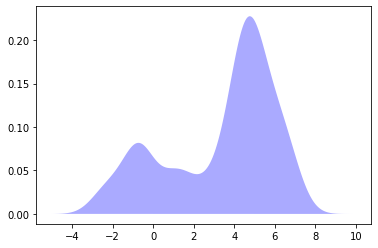

In [3]:
# Gaussian KDE con bandwith = 0.75
from sklearn.neighbors import KernelDensity 

kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
plt.fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF');

Parece razonable la estimacion de la densidad en este caso, pero lo podemos mejorar mas, eligiendo la mejor de las posibles combinaciones kernel-bandwith para los datos.

### Kernels disponibles.

<Figure size 1440x720 with 0 Axes>

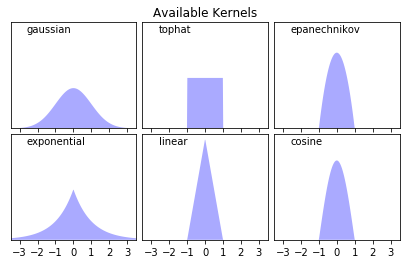

In [10]:
plt.figure(figsize=(20, 10))
X_plot = np.linspace(-10, 10, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)

for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-3.5, 3.5)

ax[0, 1].set_title('Available Kernels');

Vamos a comparar diferentes kernels para ver sus respectivas aproximaciones a la funcion de densidad multinomial:

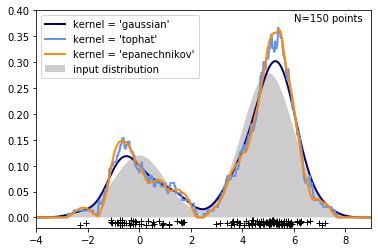

In [11]:
from scipy.stats import norm
N = 150
np.random.seed(1)

X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')
colors = ['navy', 'cornflowerblue', 'darkorange']
kernels = ['gaussian', 'tophat', 'epanechnikov']
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
            linestyle='-', label=f"kernel = '{kernel}'")

ax.text(6, 0.38, f"N={N} points")

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show();

En el ejemplo anterior tenemos que con una aproximacion de $N = 150$ podemos conseguir una aproximacion bastante buena de la funcion de densidad, pero, podemos hacerlo mejor?, la respuesta es si, existen hyperparametros a optimizar para acercarnos lo mejor posible a la representacion que queremos conseguir.

En nuestro caso dichos hyperparametros son "bandwith" y la eleccion del kernel.

Con el primer caso lo que queremos conseguir es el "sweet point" entre un bandwith muy bajo lo que da poca informacion de los vecinos cercanos a cada punto y un bandwith muy alto que provoca un estado de "oversmooth" haciendo que puntos muy alejados tengan un peso demasiado elevado para el punto a estimar y por lo tanto se generen regiones con alta densidad donde no deberia.

La manera en la que vamos a buscar dichos hiperparametros es mediante k-fold cross validation, un metodo empirico para asegurarnos de que los hyperparametros que encontramos son estadisticamente robustos a nuevos datos es decir a generalizar correctamente.

Nota: exiten otros metodos para la seleccion del parametro bandwith como la regla de Silverman o metricas de AIC, BIC, heuristicas etc pero la mayor parte de las veces merece la pena estimarlo empiricamente con los datos de la muestra que tenemos ya que las reglas anteriormente citadas se basan en supuestos de la forma de la distribucion y son mucho menos flexibles.

En scikit learn podemos utilizar GridSearch con una lista de parametros para la funcion estimadora, tambien se puede utilizar RandomizedSearchCV que en vez de buscar todos los parametros en una busqueda de "grid" los busca de manera aleatoria con un numero predeterminado de iteraciones y esta probado que genera una mejora en cuanto a la velocidad de la busqueda con respecto al GridSearch de un optimo local.

En el caso que nos trae vamos a buscar sobre todos los parametros ya que son pocos datos, pero recomiendo probar el otro metodo para futuras busquedas de parametros o probar metodos metaheuristicos de busqueda o metodos de optimizacion bayesiana.

En este caso vamos a utilizar mas puntos para la estimacion, 10000 en este caso para mejorar la visualizacion.

In [12]:
from sklearn.model_selection import GridSearchCV

N = 2500
np.random.seed(1)

X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

params = {'bandwidth': np.linspace(0.1, 1.0, 30),
        'kernel': ['gaussian', 'tophat', 'epanechnikov',
                    'exponential', 'linear', 'cosine']}

grid = GridSearchCV(KernelDensity(),
                    param_grid=params,
                    cv=10, n_jobs=-1)
grid.fit(X)
print(grid.best_params_)

{'bandwidth': 0.34827586206896555, 'kernel': 'tophat'}


Podemos ver que la mejor aproximacion la hace un bandwith de 0.35 y un kernel tophat.

Vamos a ver como se ve dicha aproximacion.

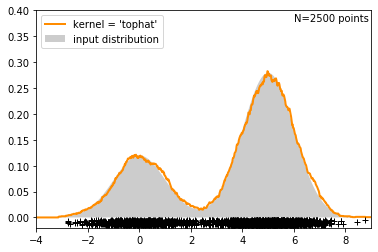

In [13]:
fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')

kde = KernelDensity(kernel=grid.best_params_['kernel'],bandwidth=grid.best_params_['bandwidth']).fit(X)
log_dens = kde.score_samples(X_plot)
ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
        linestyle='-', label=f"kernel = '{grid.best_params_['kernel']}'")

ax.text(6, 0.38, f"N={N} points")

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show();

Podemos ver que la estimacion es practicamente perfecta, si bien es cierto a medida que aumentamos la cantidad de puntos para la estimacion se hace mas facil y practicamente cualquier kernel funciona correctamente.

## Conclusion

Espero que les haya aclarado algunas dudas sobre como funciona KDE y en las situaciones en las que es aplicable.